In [1]:
import pandas as pd
import numpy as np
import tf
from natasha import Segmenter, Doc
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch
from torch import nn

import torchmetrics
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import ModelSummary
from lightning.pytorch.tuner import Tuner
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks import Callback
import matplotlib.pyplot as plt

from navec import Navec
from slovnet.model.emb import NavecEmbedding

In [2]:
path = '../navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

###**Text classification with Word Embeddings**

In [79]:
# df = pd.read_csv('files/aug_gpt.csv', encoding='windows-1251', delimiter=';')
csv_file_path = 'files/14_.csv'
# dataframe = pd.read_csv('files/aug_gpt.csv', encoding='windows-1251', delimiter=';')
dataframe = pd.read_csv(csv_file_path)
dataframe

,text,category
0,Повторная отправка Рецензия Гаршиной.doc Добры...,рецензирование
1,Re: Шаблон рецензии (новый) Спасибо.Нечаев.,другое
2,RE: статья Вестник САИТ Рецензия Рецензия Толс...,рецензирование
3,RE: статья для рецензирования рецензия_на_Проб...,рецензирование
4,RE: рецензия на статью Рецензия Толстоброва на...,рецензирование
...,...,...
3439,"Доброе утро, ! Подготовленная авторами статья ...",готово к публикации
3440,Дорогой! После внесения необходимых изменений ...,готово к публикации
3441,"Доброе утро, ! Мы рады сообщить, что статья пр...",готово к публикации
3442,Дорогой! После удаления комментариев статья го...,готово к публикации


In [80]:
# new_df = pd.DataFrame(columns=dataframe.columns)
# 
# # Проходим по уникальным категориям
# for category in dataframe['category'].unique():
#     # Выбираем первые 10 вхождений каждой категории и добавляем их в новый DataFrame
#     category_subset = dataframe[dataframe['category'] == category].head(30)
#     new_df = new_df._append(category_subset)
# 
# # Сбрасываем индексы в новом DataFrame
# new_df.reset_index(drop=True, inplace=True)
# new_df
# new_df теперь содержит по 10 вхождений каждой категории из original_df

In [81]:
# y_labels = new_df.loc[:, "category"]

In [82]:
# y_labels

In [83]:
# labels = new_df['category'].unique()

In [84]:
dataframe.loc[:, "category"] = dataframe.loc[:, "category"].astype('category').cat.codes

In [85]:
c = dataframe.loc[:, "category"].astype('category')

d = dict(enumerate(c.cat.categories))
print(d)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}


In [86]:
X_text = dataframe.iloc[:, 0].values
y = dataframe.iloc[:, 1].values

In [87]:
# from sklearn.model_selection import train_test_split
# X_text, X_test, y_targets, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [88]:
dataframe['category'].unique()

array([7, 3, 6, 1, 5, 2, 0, 4], dtype=object)

In [89]:
# Нахождение максимальной длины текста (в словах)
def maxTextLen(X_text, navec):
  segmenter = Segmenter()
  text_lens = []
  for text in X_text:
    doc = Doc(text)
    doc.segment(segmenter)
    text_tokens = [token.text for token in doc.tokens if token.text in navec]
    text_lens.append(len(text_tokens))
  max_text_len = max(text_lens)
  return max_text_len

# Преобразование текста в тензор
def textToTensorDataset(X_data, y_data, max_text_len, navec):
  segmenter = Segmenter()
  num_texts = len(X_data)
  texts_tensor = torch.zeros(num_texts, max_text_len + 2).long()
  targets_tensor = torch.tensor(y_data).long()

  for text_i, text in enumerate(X_text):
    doc = Doc(text)
    doc.segment(segmenter)
    text_tokens = [token.text for token in doc.tokens if token.text in navec]
    for token_i, token in enumerate(text_tokens):
        texts_tensor[text_i, token_i + 1] = navec.vocab[token]
  return TensorDataset(texts_tensor, targets_tensor)

In [90]:
max_text_len = maxTextLen(X_text, navec)
y_data = np.array([int(label) for label in y])
train_dataset = textToTensorDataset(X_text, y_data, max_text_len, navec)

In [91]:
# max_text_len

In [92]:
# dataset_length = [i for i,_ in enumerate(train_dataset)][-1] + 1

In [93]:
# dataset_length

In [94]:
# import tensorflow as tf

In [95]:
# train_dataset.tensors[0].numpy()

In [96]:
# dataset_to_numpy = list(train_dataset.as_numpy_iterator())
# shape = tf.shape(dataset_to_numpy)
# print(shape)

In [97]:
# Сверточный слой с функцией активации LeakyRelu
class CustomConv1D(nn.Module):
  def __init__(self,
               in_channels:int,
               out_channels:int,
               kernel_size:int,
               dilation:int):
    super().__init__()
    self.conv1d = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation)
    # print(f" self.conv1d = nn.Conv1d(in_channels={in_channels}, out_channels={out_channels}, kernel_size={kernel_size}, stride=1, padding={kernel_size // 2}, dilation={dilation})")
    
    self.activation = nn.LeakyReLU(0.2)

  def forward(self, x):
    x = self.conv1d(x)
    x = self.activation(x)
    return x

In [98]:

class TokenCNN(nn.Module):
  def __init__(self,
               in_embed_size:int,
               context_embed_size:int):
    super().__init__()
    
    # print(f"self.conv_1_1 = CustomConv1D(in_channels={in_embed_size}, out_channels={context_embed_size}, kernel_size=7, dilation=1)")
    
    self.conv_1_1 = CustomConv1D(in_channels=in_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    
    # print(f"self.conv_1_2 = CustomConv1D(in_channels={context_embed_size}, out_channels={context_embed_size}, kernel_size=3, dilation=1)")
    self.conv_1_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_1 = nn.MaxPool1d(kernel_size=3, stride=3)

    self.conv_2_1 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    self.conv_2_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_2 = nn.MaxPool1d(kernel_size=3, stride=3)
    
    self.dropout1 = nn.Dropout1d(p=0.4)

    self.conv_3_1 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    self.conv_3_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_3 = nn.MaxPool1d(kernel_size=3, stride=3)

    self.conv_4_1 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=7, dilation=1)
    self.conv_4_2 = CustomConv1D(in_channels=context_embed_size, out_channels=context_embed_size, kernel_size=3, dilation=1)
    self.pooling_4 = nn.MaxPool1d(kernel_size=3, stride=3)
    

  def forward(self, x):
    x = self.conv_1_1(x)
    x = x + self.conv_1_2(x)
    x = self.pooling_1(x)

    x = self.conv_2_1(x)
    x = x + self.conv_2_2(x)
    x = self.pooling_2(x)

    x = self.dropout1(x)
    
    x = self.conv_3_1(x)
    x = x + self.conv_3_2(x)
    x = self.pooling_3(x)

    x = self.conv_4_1(x)
    x = x + self.conv_4_2(x)
    x = self.pooling_4(x)

    return x

In [99]:
# Завершающий линейный слой с дропаутом
class ClassificationHead(nn.Module):
  def __init__(self,
               in_features:int,
               out_features:int,
               dropout:float):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.classifier = nn.Linear(in_features=in_features, out_features=out_features)

  def forward(self, x):
    x = self.dropout(x)
    x = self.classifier(x)
    return x

In [100]:
# Реализация сети
class Network(nn.Module):
    def __init__(self,
                 num_classes,
                 max_text_len,
                 token_embedding_size=256,
                 classifier_dropout=0.3):
        super().__init__()
        self.embeddings = NavecEmbedding(navec)
        self.token_cnn = TokenCNN(in_embed_size=token_embedding_size, context_embed_size=token_embedding_size)
        # print(f"TokenCNN(in_embed_size={token_embedding_size}, context_embed_size={token_embedding_size})")
        # self.token_cnn2 = TokenCNN(in_embed_size=token_embedding_size, context_embed_size=token_embedding_size)
        # self.token_rnn = TokenCNNRNN(max_text_len=max_text_len, in_embed_size=300, context_embed_size=token_embedding_size, num_layers=1) # todo
        
        self.global_pooling_context = nn.AdaptiveMaxPool1d(1)
        self.classification_head = ClassificationHead(in_features=token_embedding_size, out_features=num_classes, dropout=classifier_dropout)
        # print(f"ClassificationHead(in_features={token_embedding_size}, out_features={num_classes}, dropout=classifier_dropout)")

    def forward(self, tokens):
        # BatchSize x MaxTextLen
        batch_size, max_text_len = tokens.shape 
        # print(f"{batch_size}, {max_text_len} = tokens.shape ")
        
        # BatchSize x MaxTokenLen x EmbSize
        word_embeddings = self.embeddings(tokens)    
        # BatchSize x EmbSize x MaxTextLen
        word_embeddings = word_embeddings.permute(0, 2, 1) 
        # BatchSize x EmbSize x MaxTextLen
        context_features = self.token_cnn(word_embeddings) # todo      
        # context_features = self.token_cnn2(context_features)
        text_features = self.global_pooling_context(context_features).squeeze(-1)  
        # BatchSize x EmbSize
        logits = self.classification_head(text_features)                           # BatchSize x num_classes
        return logits

In [101]:
class DataModule(pl.LightningDataModule):
  def __init__(self,
               tensor_dataset,
               batch_size):
    super().__init__()
    self.tensor_dataset = tensor_dataset
    self.batch_size = batch_size
    self.prepare_data()

  def setup(self, stage=None):
    train_size = int(0.6 * len(self.tensor_dataset))
    test_size = int(0.2 * len(self.tensor_dataset))
    val_size = len(self.tensor_dataset) - train_size - test_size
    self.train_data, self.test_data, self.val_data = random_split(self.tensor_dataset, [train_size, test_size, val_size])
    return self.train_data, self.test_data, self.val_data

  def train_dataloader(self):
    return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=2)
  
  def test_dataloader(self):
    return DataLoader(self.val_data, batch_size=self.batch_size, shuffle = False, num_workers=2)

  def val_dataloader(self):
    return DataLoader(self.val_data, batch_size=self.batch_size, shuffle = False, num_workers=2)
  
  def predict_dataloader(self):
    return DataLoader(self.val_data, batch_size=self.batch_size, shuffle = False, num_workers=2)

In [102]:
# Создание модели
class ModelCompilation(pl.LightningModule):
    def __init__(self,
                 model:torch.nn.Module,
                 metrics:dict,
                 loss_function,
                 optimizer:torch.optim,
                 learning_rate:float):
        super().__init__()
        self.model = model
        self.metrics = metrics
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.save_hyperparameters(logger=False)

    def forward(self, x):
        pred = self.model.forward(x)
        return pred

    def configure_optimizers(self):
        train_optimizer = self.optimizer(self.parameters(), lr=self.learning_rate, weight_decay=0.05, betas = (0.9, 0.98), eps = 1.0e-9)
        train_scheduler = {
            "scheduler": ReduceLROnPlateau(optimizer=train_optimizer, mode="min", factor=0.1, patience=1, min_lr=5e-6),
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss",
        }
        return [train_optimizer], [train_scheduler]

    def training_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch, batch_idx, 'train')
        return loss

    def validation_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch, batch_idx, 'val')
        return loss

    def test_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch, batch_idx, 'test')
        return loss

    def common_step(self, batch, batch_idx, stage):
        x, y = batch
        pred = self.forward(x)
        loss = self.loss_function(pred, y)
        if (stage == 'test') or (stage == 'val'):
            on_step = False
        else:
            on_step = True

        [self.log(stage + '_' + metric_name, metric(pred, y).to(device), on_step=on_step, on_epoch=True, prog_bar=True, logger=True) for metric_name, metric in self.metrics.items()]
        self.log(stage + '_' + 'loss', loss, on_step=on_step, on_epoch=True, prog_bar=True, logger=True)
        return loss, pred, y

In [103]:
class History(Callback):
    def __init__(self):
        self.history = {'val_loss': np.array([]), 'val_accuracy': np.array([]), 'train_loss_epoch' : np.array([]), 'train_accuracy_epoch' : np.array([])}

    def on_train_epoch_end(self, trainer, module):
        logs = trainer.logged_metrics
        self.history['train_loss_epoch'] = np.append(self.history['train_loss_epoch'], logs['train_loss_epoch'].cpu())
        self.history['val_loss'] = np.append(self.history['val_loss'], logs['val_loss'].cpu())
        self.history['train_accuracy_epoch'] = np.append(self.history['train_accuracy_epoch'], logs['train_accuracy_epoch'].cpu())
        self.history['val_accuracy'] = np.append(self.history['val_accuracy'], logs['val_accuracy'].cpu())

In [104]:
from sklearn.utils import class_weight

class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
class_weights=torch.tensor(class_weights,dtype=torch.float)
 
class_weights

tensor([0.6185, 3.2614, 0.8408, 0.7743, 3.3633, 0.6562, 1.5598, 0.8822])

In [105]:
# Обучение модели
def fit(iteration):
  num_classes = 8
  task = 'multiclass'
  network = Network(num_classes=num_classes,
                    max_text_len=max_text_len,
                    token_embedding_size=300,
                    classifier_dropout=0.5
                    )

  metrics = {'accuracy': torchmetrics.Accuracy(task=task, num_classes=num_classes).to(device)}
  loss_function = nn.CrossEntropyLoss(weight=class_weights) #
  optimizer = torch.optim.AdamW
  learning_rate = 0.0005

  earlystopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
  checkpoint_callback = ModelCheckpoint(monitor='val_loss', filename='model-{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}')
  history_callback = History()

  model = ModelCompilation(network, metrics, loss_function, optimizer, learning_rate)
  trainer = pl.Trainer(callbacks=[earlystopping_callback, history_callback, checkpoint_callback], precision='32', accelerator=device, devices=1, max_epochs=50)

  trainer.fit(model, datamodule=data_module)
  print("Best model score for iteration " + str(iteration) + " : " + str(checkpoint_callback.best_model_score))
  return checkpoint_callback, history_callback

In [107]:
# Обучение моделей заданное количество раз и выбор лучшей модели
device = 'cpu'
trials = 1
best_score = 100
best_model_path = ''
data_module = DataModule(tensor_dataset=train_dataset, batch_size=64)
for i in range(trials):
  checkpoint, history = fit(i)
  if(checkpoint.best_model_score < best_score):
    best_score = checkpoint.best_model_score
    best_model_path = checkpoint.best_model_path
    best_history = history

print("Best model score for " + str(trials) + " trials: " + str(best_score))
print("Best model path: " + best_model_path)

F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'loss_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_function'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Network          | 53.7 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
3.6 M     Trainable params
5

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
F:\Projects\Python\techAI\MailManagementApp\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best model score for iteration 0 : tensor(0.5035)
Best model score for 1 trials: tensor(0.5035)
Best model path: F:\Projects\Python\MailManagementApp\jupiter\lightning_logs\version_51\checkpoints\model-epoch=08-val_loss=0.50-val_accuracy=0.82.ckpt


In [108]:
# Вывод графиков
def plot_train_metrics(history_callback):
  plt.figure()
  plt.plot(list(range(len(history_callback.history['train_loss_epoch']))), history_callback.history['train_loss_epoch'])
  plt.plot(list(range(len(history_callback.history['val_loss']))), history_callback.history['val_loss'])
  plt.legend(['train_loss', 'val_loss'])

  plt.figure()
  plt.plot(list(range(len(history_callback.history['train_accuracy_epoch']))), history_callback.history['train_accuracy_epoch'])
  plt.plot(list(range(len(history_callback.history['val_accuracy']))), history_callback.history['val_accuracy'])
  plt.legend(['train_accuracy', 'val_accuracy'])
  plt.show()

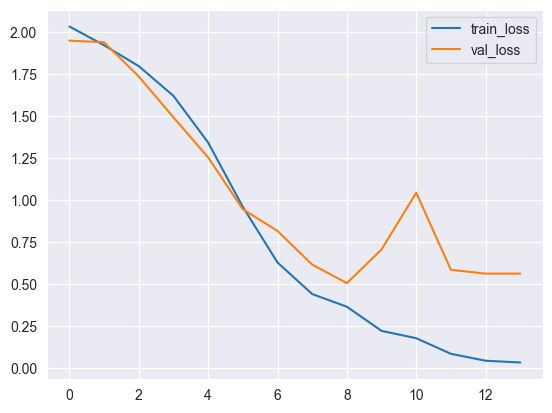

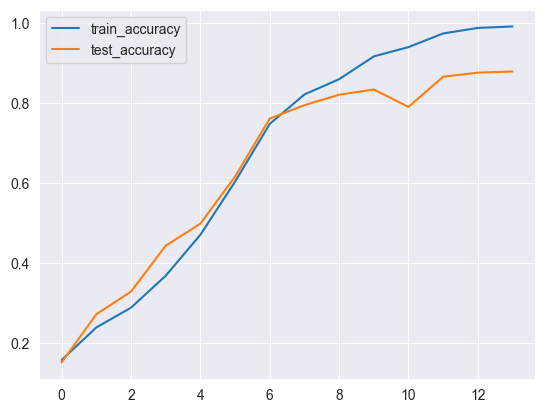

In [109]:
plot_train_metrics(best_history)

In [110]:
# Загрузка предобученной модели
def load_pretrained_model(checkpoint_path):
  num_classes = 8
  task = 'multiclass'
  network = Network(num_classes=num_classes,
                    max_text_len=max_text_len,
                    token_embedding_size=256,
                    classifier_dropout=0.5
                    )

  metrics = {'accuracy': torchmetrics.Accuracy(task=task, num_classes=num_classes).to(device)}
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW
  learning_rate = 0.0005

  model = ModelCompilation(network, metrics, loss_function, optimizer, learning_rate)
  model = ModelCompilation.load_from_checkpoint(checkpoint_path)
  return model

In [111]:
# Предсказание категории
def predictCategory(text, model, navec, max_text_len):
  texts_tensor = torch.zeros(1, max_text_len + 2).long()
  text = text.lower()
  segmenter = Segmenter()
  doc = Doc(text)
  doc.segment(segmenter)
  text_tokens = [token.text for token in doc.tokens if token.text in navec]
  for token_i, token in enumerate(text_tokens):
      texts_tensor[0][token_i + 1] = navec.vocab[token]

  model.eval()
  logits = model.forward(texts_tensor)
  proba = torch.nn.functional.softmax(logits.data, dim=1)
  return proba

In [112]:
best_model_path = 'lightning_logs/version_48/checkpoints/model-epoch=20-val_loss=0.28-val_accuracy=0.93.ckpt'
model = load_pretrained_model(best_model_path)

In [113]:
text = '''Здрвствуйте! ВАша статья отклоняется по причине несоответсвия тематике'''

In [114]:
prob = predictCategory(text, model, navec, max_text_len)
prob

tensor([[8.5380e-01, 3.0235e-06, 5.3380e-05, 8.5852e-02, 1.7512e-04, 6.0035e-02,
         2.2730e-05, 5.4492e-05]])

In [115]:
categories = ["вопросы", "готово к публикации",
              "доработка", "другое", "отклонена",
              "подача статьи", "проверка статьи", "рецензирование"]
# {0: 'вопросы', 1: 'готово к публикации', 2: 'доработка', 3: 'другое', 4: 'отклонена', 5: 'подача статьи', 6: 'проверка статьи', 7: 'рецензирование'}
result = {}
for i in range(len(categories)):
  category = categories[i]
  result[category] = prob[0][i]
  result_sorted = sorted(result.items(), key=lambda x: x[1], reverse=True)

res = ''
for s, p in result_sorted:
  res = res + f'{s} : {p:.5f}\n'

print(res)

вопросы : 0.85380
другое : 0.08585
подача статьи : 0.06003
отклонена : 0.00018
рецензирование : 0.00005
доработка : 0.00005
проверка статьи : 0.00002
готово к публикации : 0.00000


In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
y_dict = {0: 'вопросы', 1: 'готово к публикации', 2: 'доработка', 3: 'другое', 4: 'отклонена', 5: 'подача статьи', 6: 'проверка статьи', 7: 'рецензирование'}

In [118]:
def predict(text):
    
    categories = ["вопросы", "готово к публикации",
              "доработка", "другое", "отклонена",
              "подача статьи", "проверка статьи", "рецензирование"]
    result = {}
    res = ''
    if text is not None and text != '':
        prob = predictCategory(text, model, navec, max_text_len)
        for i in range(len(categories)):
            category = categories[i]
            result[category] = prob[0][i]

        result_sorted = sorted(result.items(), key=lambda x: x[1], reverse=True)
        
    else:
        res = "Warning!"

    return result_sorted[0][0]

In [119]:
text = '''здравствуйте отправляю вам статью с внесёнными изменениями в соответствии с замечаниями рецензента к статье прилагаю необходимые материалы'''
predict(text)

'доработка'

In [120]:
# {0: 'вопросы', 1: 'готово к публикации', 2: 'доработка', 3: 'другое', 4: 'отклонена', 5: 'подача статьи', 6: 'проверка статьи', 7: 'рецензирование'}
categories = ["вопросы", "готово к публикации",
              "доработка", "другое", "отклонена",
              "подача статьи", "проверка статьи", "рецензирование"]

result = {}
for i in range(len(categories)):
  category = categories[i]
  result[category] = prob[0][i]
  result_sorted = sorted(result.items(), key=lambda x: x[1], reverse=True)

In [121]:
texts = new_df['text']
y_labels = new_df['category']

NameError: name 'new_df' is not defined

In [ ]:
list(y_labels)

In [ ]:
pred = [predict(text) for text in texts]
pred

In [ ]:
# pred = [predict(text) for text in X_text]
mat = confusion_matrix(y_labels, pred)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=labels,yticklabels=labels, cmap="crest")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()